# Visualization wearing mask (Convolutional Classifier)

## 1. Import files + Configuration on the repositories

### Observation : It's important to the next steps to indicate the correct labels of the classes on the picture's repositories .

In [1]:
import os
import glob
path_test = r'C:\Users\PC MSI\Documents\Anaconda NoteBook\Face Mask Dataset\Test'
path_train = r'C:\Users\PC MSI\Documents\Anaconda NoteBook\Face Mask Dataset\Train'
path_validation = r'C:\Users\PC MSI\Documents\Anaconda NoteBook\Face Mask Dataset\Validation'

## 2. Import libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

### Observation : These days, convnets are rarely trained from scratch. More often, we reuse the base of a pretrained model. To the pretrained base we then attach an untrained head. In other words, we reuse the part of a network that has already learned to do 1. Extract features, and attach to it some fresh layers to learn 2. Classify.

## 3. Preprocessing on the set of data in real-time + Pipeline of the pictures preprocessing generation into a defined set. Splitting presentation.

In [3]:
image_size = (128,128)

#ImageDataGenerator() generates batches of tensor image data with real-time data augmentation
#horizontal_flip returns boolean and randomly flips inputs horizontally.
#rescale rescales factor by defaults to none and if none or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).

train_gen = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rescale=1./255
)
val_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

#flow_from_directory() allows to parameter the sets.
#target_size scales the picutres.
#seed is an optional random seed for shuffling and transformations.

train_ds = train_gen.flow_from_directory(path_train,target_size=image_size,seed=42)
val_ds = val_gen.flow_from_directory(path_validation,target_size=image_size,seed=42)
test_ds = test_gen.flow_from_directory(path_test,target_size=image_size,seed=42)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


## 4. Showing some images

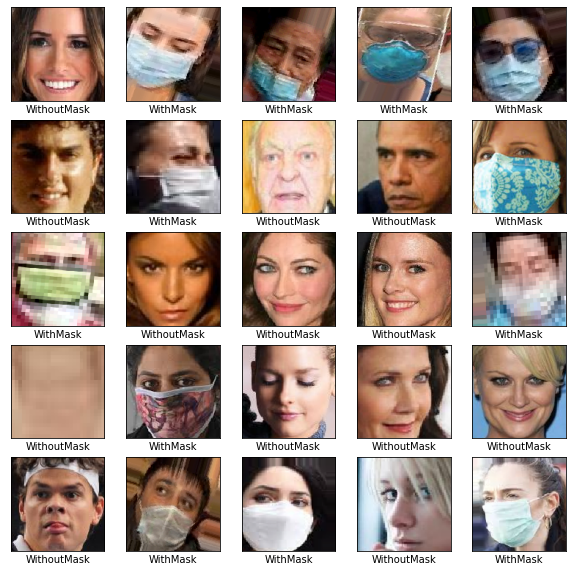

In [4]:
# mapping of classes with their key-value (.items())
class_names = {v:k for k,v in train_ds.class_indices.items()}

# fetching items with iteration of key-values (.iter())
images,labels = next(iter(train_ds))

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[labels[i][1]])

plt.show()

## 5. Model's building

### 5.1. VGG19 model initialisation and configuration

In [5]:
# initialisation of the vgg19 model
initial_model = keras.applications.VGG19(include_top=False,input_shape=image_size+(3,))
initial_model.trainable = False

# initialisation of the layers with flattening (flatten()) in input and determination about the number of layers and activation function (Dense()) in output.
# Flatten() transforms the two dimensional outputs of the base into the one dimensional inputs needed by the head.
# Dense(2,activation) determine the number of layers (2) with the numbers of neurons or units (2) and the function of activation (sigmoïd)
# The sigmoïd activation produces class probabilities, it gets the final class prediction, we define a threshold probability. Typically this will be 0.5, so that rounding will give us the correct class: below 0.5 means the class with label 0 and 0.5 or above means the class with label 1.

model = keras.Sequential([
    initial_model,
    layers.Flatten(),
    layers.Dense(2,activation='sigmoid')
])

# model.compile allows to train the data. It allows to make to learn the neural network.
# the loss function measures the acuracy of the predictions and guides for finding the corrects values. It determines the disparity between the target's true values and the target's false values .
# the optimizer determine how to change the weights. It adjusts the weights to minimize te loss. The algorithms use the stochastic gradient descent. There 3 steps: sampling of training data and running model for predictions, measuring the loss, adjusting the weights with a direction for the smallest loss. 
# the learning rate and the size of the minibatchs(a set into the training data) are important to hyperparameter. Adam has an adapative learning rate algorithm.
# BinaryCrossentropy() is a sort of measure for the distance from one probability distribution to another.the changes are smoothly not in jumps.
# metrics.BinaryAccuracy() calculates how often predictions match binary labels. This metric creates two local variables, total and count that are used to compute the frequency with which y_pred matches y_true. This frequency is ultimately returned as binary accuracy: an idempotent operation that simply divides total by count.
#If sample_weight is None, weights default to 1. Use sample_weight of 0 to mask values.

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

80142336/80134624 [==============================] - 5s 0us/step


## 5.2. Presentation of the networks model

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


## 5.3. Complexity's improvement of the model by the simplicity

In [7]:
# We want that the gap on the learninng curves between the validation data and training data be short.
# The learning curves about the training data determine signal and noise.
# The learning curves about the Validation data determine the signal only.
# Underfitting -> not enough signal
# Overfitting -> too much noise


# keras.callbacks.EarlyStopping() stops training when a monitored metric has stopped improving. To reduce the learning on the noise.
# Early stopping the short gap between the two learnings curves and the point before that the validation learning curves rises.

early_stopping = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',mode='max',patience=4, restore_best_weights=True)

# the EarlyStopping function is a callback function, it runs every so often while the network trains, after every epoch.
# monitor: quantity to be monitored, patience determine the number of Epochs before stopping, mode:max:: mode it will stop when the quantity monitored has stopped increasing, restore_best_weights:Whether to restore model weights from the epoch with the best value of the monitored quantity.


In [8]:
# ReduceLROnPlateau function reduces learning rate when a metric has stopped improving.
# Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy',factor=0.5, patience=2,verbose=1)

## 5.4. Presentation of the Complexity's improvement of the model

In [9]:
history = model.fit(train_ds,batch_size=32,epochs=30, validation_data=val_ds,callbacks=[early_stopping,reduce_lr])

Epoch 1/30
313/313 [==============================] - 486s 2s/step - loss: 0.1659 - binary_accuracy: 0.9380 - val_loss: 0.0385 - val_binary_accuracy: 0.9887
Epoch 2/30
313/313 [==============================] - 463s 1s/step - loss: 0.0351 - binary_accuracy: 0.9899 - val_loss: 0.0183 - val_binary_accuracy: 0.9981
Epoch 3/30
313/313 [==============================] - 441s 1s/step - loss: 0.0261 - binary_accuracy: 0.9921 - val_loss: 0.0147 - val_binary_accuracy: 0.9994
Epoch 4/30
313/313 [==============================] - 458s 1s/step - loss: 0.0179 - binary_accuracy: 0.9953 - val_loss: 0.0170 - val_binary_accuracy: 0.9975
Epoch 5/30
313/313 [==============================] - 442s 1s/step - loss: 0.0163 - binary_accuracy: 0.9954 - val_loss: 0.0089 - val_binary_accuracy: 0.9994

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/30
313/313 [==============================] - 459s 1s/step - loss: 0.0118 - binary_accuracy: 0.9975 - val_loss: 0.0076 - val_b

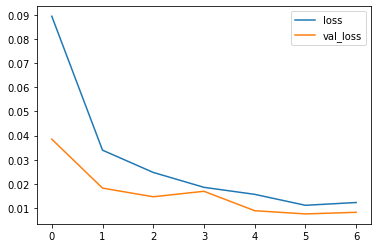

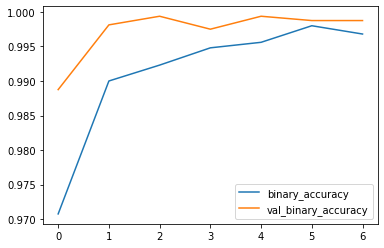

In [10]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

## 6. Hyperparametrisation

In [11]:
initial_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.00001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',mode='max', patience=4,restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy',factor=0.5,patience=2,verbose=1)

history = model.fit(train_ds,batch_size=32,epochs=30, validation_data=val_ds,callbacks=[early_stopping,lr_scheduler])

Epoch 1/30
313/313 [==============================] - 2231s 7s/step - loss: 0.0203 - binary_accuracy: 0.9932 - val_loss: 8.2399e-04 - val_binary_accuracy: 1.0000
Epoch 2/30
313/313 [==============================] - 2307s 7s/step - loss: 0.0029 - binary_accuracy: 0.9991 - val_loss: 7.6817e-04 - val_binary_accuracy: 1.0000
Epoch 3/30
313/313 [==============================] - 2345s 7s/step - loss: 0.0084 - binary_accuracy: 0.9981 - val_loss: 3.0762e-04 - val_binary_accuracy: 1.0000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 4/30
313/313 [==============================] - 2108s 7s/step - loss: 0.0011 - binary_accuracy: 0.9998 - val_loss: 6.5764e-05 - val_binary_accuracy: 1.0000
Epoch 5/30
313/313 [==============================] - 2103s 7s/step - loss: 4.0654e-04 - binary_accuracy: 1.0000 - val_loss: 5.3144e-05 - val_binary_accuracy: 1.0000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.


## 7. Presentation loss and metrics value of the model for the test set.

In [1]:
model.evaluate(test_ds)
model.save('maskmodel3.h5')
model.save_weights('maskmodel2.h5')

NameError: name 'model' is not defined

## 8. Treatment on the pictures

In [13]:
# We choice the model opencv Haarcascade what allows us to englobe the coordinates of faces. And to decrypt if the persons have a mask or not. 

detection_model = cv2.CascadeClassifier(r'D:\Technocite\DATASETS PROJET\haarcascade_frontalface_default.xml')

In [14]:
# We specify the markers (the labels and the colors)
mask_label = {0:'AVEC MASQUE',1:'SANS MASQUE'}
color_label = {0:(0,255,0),1:(255,0,0)}

In [15]:
# We define the prediction function with the path of the picture in parameter
# imread read the picture
# But there are flags in opencv what decide if the picture is opened or not. We add then the conversion for this flags with cvtColor and IMREAD_GRAYSCALE
def predict(image_path):
    
    model = tf.keras.models.load_model('maskmodel.h5')
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # We use detectMultiScale() to find faces 
    # scaleFactor : Parameter specifying how much the image size is reduced at each image scale.
    # minNeighbors : Parameter specifying how many neighbors each candidate rectangle should have to retain it. This parameter will affect the quality of the detected faces: higher value results in less detections but with higher quality.
    faces = detection_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=9)
    
    #Probabilité que ce soit un visage!!!
    
    #If faces are found, it returns the positions of detected faces as Rect(x,y,w,h)
    
    #cv2.cvtColor(img, cv2.COLOR_RGB2BGR) returns the image without swapping colour channels.
    output_img = cv2.imread(image_path)
    output_img = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)

    
    plt.figure(figsize=(20,20))
    plt.imshow(output_img)
    
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        # crop of the face 
        crop = output_img[y:y+h,x:x+w]
        # resize(src, dsize) Resizing an image means changing the dimensions of it. dsize : desired size for the output image.
        crop = cv2.resize(crop,(128,128))
        #And let’s now reshape this 1D list into a 2D matrix, pretending that it is an image (/255 for the colors)
        crop = np.reshape(crop,[1,128,128,3])/255.0
        #numpy.argmax() : Returns the indices of the maximum values along an axis.
        prediction = model.predict(crop).argmax()
        #cv2.rectangle(image, start_point, end_point, color, thickness)
        cv2.rectangle(output_img,(x,y),(x+w,y+h),color_label[prediction],1)
    
    plt.imshow(output_img)

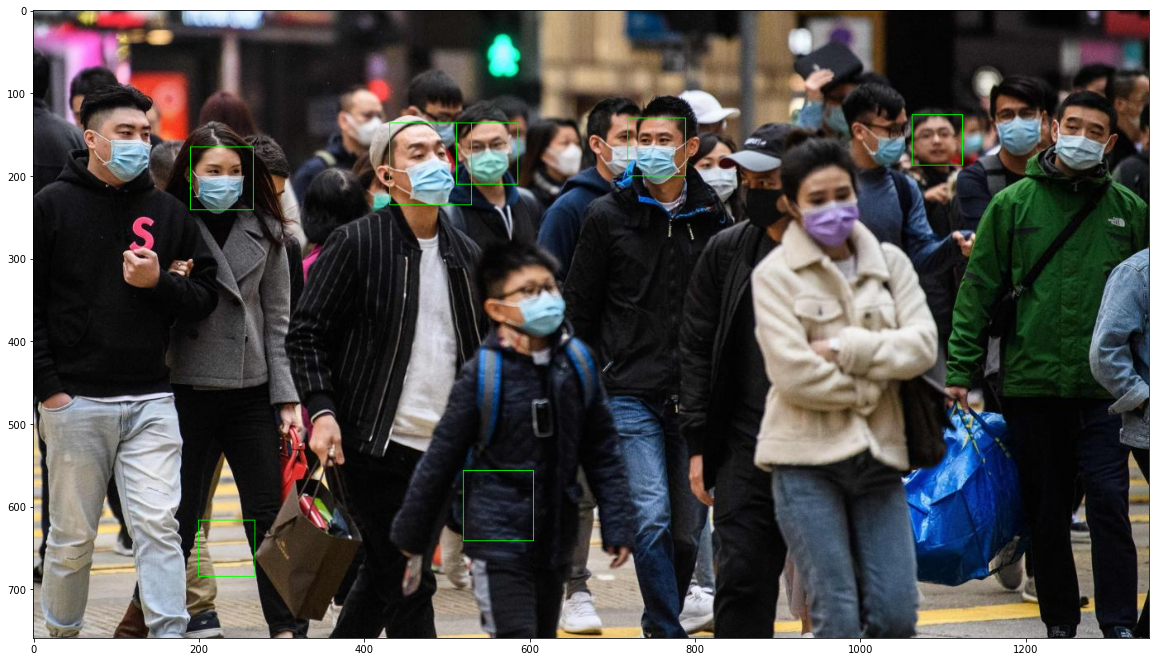

In [16]:
predict(r'D:\Technocite\DATASETS PROJET\test.jpg')

In [17]:
#predict(r'C:\Users\s_10327_ia\Desktop\image-test\5fe2693ccb5fb04b1a0ca0353809b0d00e61a72c_field_mise_en_avant_principale_1_0.jpg')